In [2]:
!pip install "gluonts[mxnet,pro]"
!pip install "gluonts[torch,pro]"
!pip install yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.6/184.6 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 24.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.3 MB/s eta 0:00:00
  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 71.6 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730985 sha256=a7bbfd6e2354d9c85d9ecfcc64ce02ca2af5883194e0d266c814d479483fbb73
  Stored in directory: /home/vincent/.cache/pip/wheels/33/3d/82/4579e9cca41ff991140b2e050bc6df3a38292f26e4fa06b15d
Successfully built pymeeus
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20
    Uninstalling graphviz-0.20:
      Successfully uninstalled graphviz-0.20
     ━━━━━━━━━━━━

In [3]:
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import seaborn as sns
import warnings
import numpy as np

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (30, 10)})

import sys
import os

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## GlutonTs Basic Example

100%|██████████| 50/50 [00:01<00:00, 26.72it/s, epoch=5/5, avg_epoch_loss=3.97]


<AxesSubplot:>

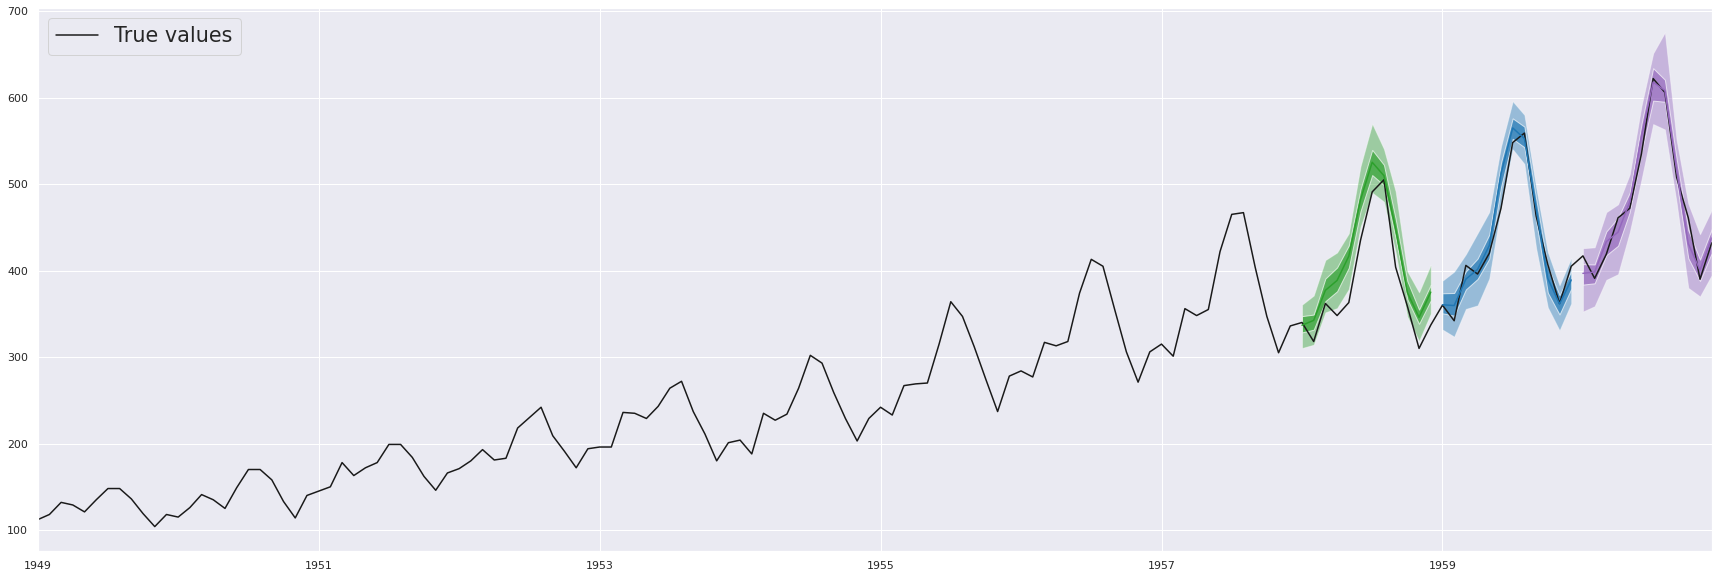

In [6]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer

dataset = get_dataset("airpassengers")

estimator = DeepAREstimator(prediction_length=12, freq="M", trainer=Trainer(epochs=5))
model = estimator.train(dataset.train)

# Make predictions
true_values = to_pandas(list(dataset.test)[0])
true_values.to_timestamp().plot(color="k")

prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-12]])
predictions = model.predict(prediction_input)

for color, prediction in zip(["green", "blue", "purple"], predictions):
    prediction.plot(color=f"tab:{color}")

plt.legend(["True values"], loc="upper left", fontsize="xx-large")

100%|██████████| 50/50 [00:00<00:00, 52.38it/s, epoch=5/5, avg_epoch_loss=4.93]


<AxesSubplot:>

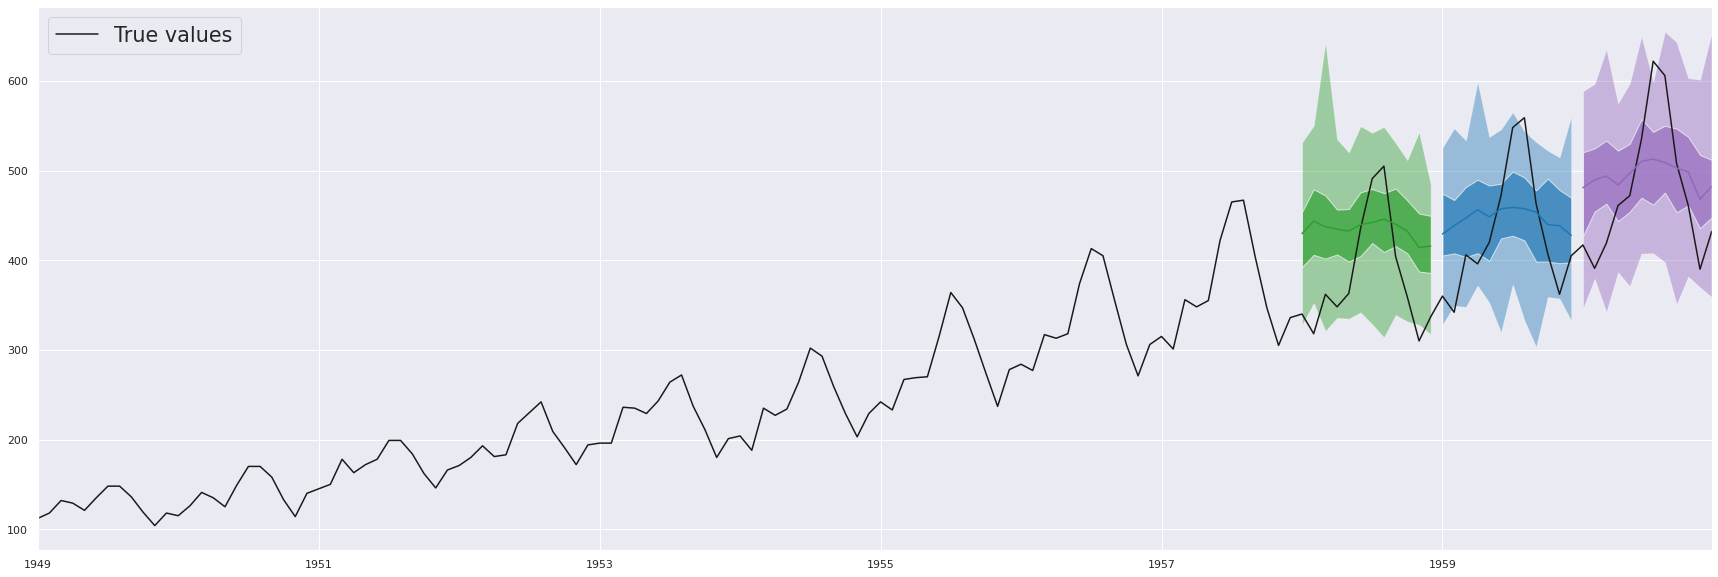

In [7]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.transformer import TransformerEstimator
from gluonts.mx import Trainer

dataset = get_dataset("airpassengers")

estimator = TransformerEstimator(prediction_length=12, freq="M", trainer=Trainer(epochs=5))
model = estimator.train(dataset.train)

# Make predictions
true_values = to_pandas(list(dataset.test)[0])
true_values.to_timestamp().plot(color="k")

prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-12]])
predictions = model.predict(prediction_input)

for color, prediction in zip(["green", "blue", "purple"], predictions):
    prediction.plot(color=f"tab:{color}")

plt.legend(["True values"], loc="upper left", fontsize="xx-large")

## BTC-USD Dataset

In [153]:
df_btc_usd = yf.download("BTC-USD")
df_btc_usd.shape
df_btc_usd.dtypes
df_btc_usd.columns
df_btc_usd.head()
df_btc_usd.index

df_btc_usd = df_btc_usd.asfreq('d')
pd.infer_freq(df_btc_usd.asfreq('d').index)

[*********************100%***********************]  1 of 1 completed


(2940, 6)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2022-09-25', '2022-09-26', '2022-09-27', '2022-09-28',
               '2022-09-29', '2022-09-30', '2022-10-01', '2022-10-02',
               '2022-10-03', '2022-10-04'],
              dtype='datetime64[ns]', name='Date', length=2940, freq=None)

'D'

In [154]:
# keep only CLose column
df_btc_usd = pd.DataFrame(df_btc_usd['Close'])
df_btc_usd = df_btc_usd[df_btc_usd.index > '2021-01-01']
df_btc_usd.shape

(641, 1)

<AxesSubplot:xlabel='Date'>

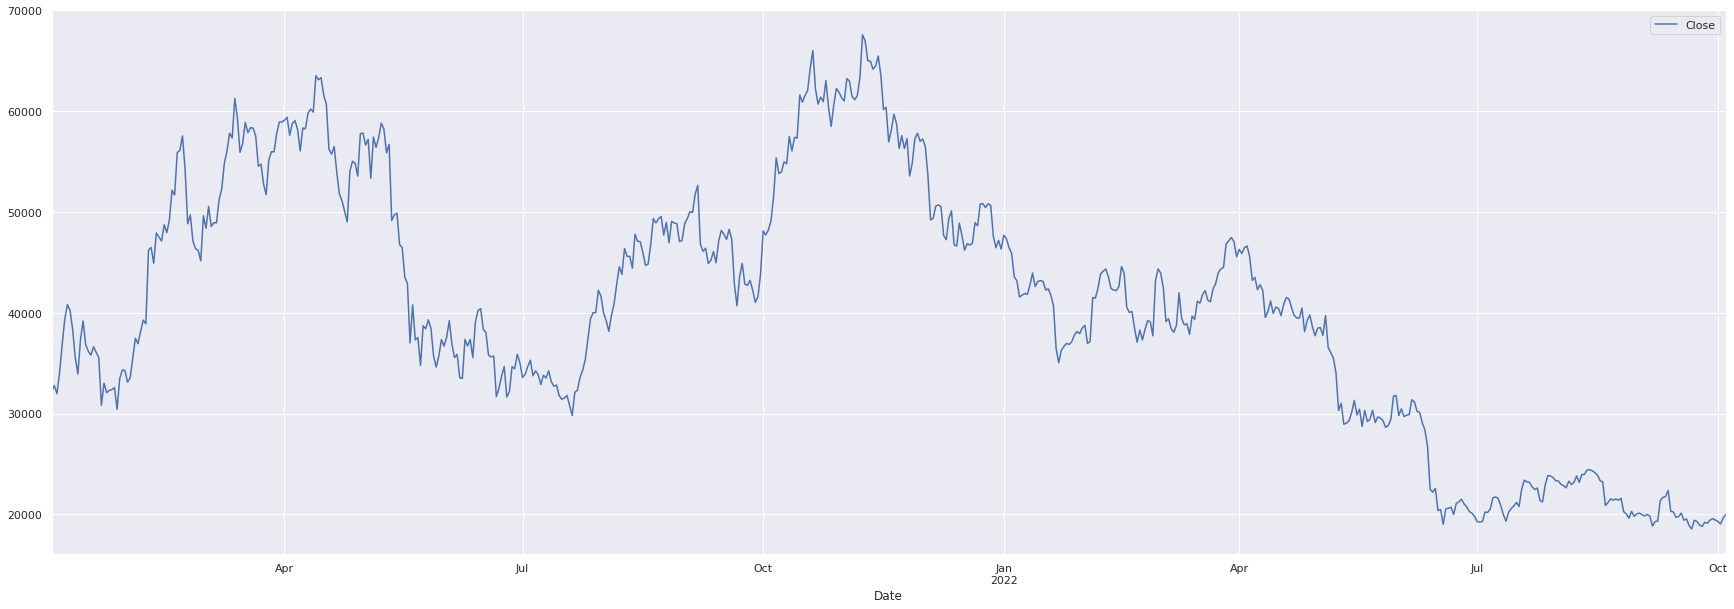

In [155]:
df_btc_usd.plot()

In [156]:
type(df_btc_usd)
type(df_btc_usd.index)
# df_btc_usd.index = df_btc_usd.index.strftime('%Y-%m-%d')
df_btc_usd

pandas.core.frame.DataFrame

pandas.core.indexes.datetimes.DatetimeIndex

,Close
Date,
2021-01-02,32127.267578
2021-01-03,32782.023438
2021-01-04,31971.914062
2021-01-05,33992.429688
2021-01-06,36824.363281
...,...
2022-09-30,19431.789062
2022-10-01,19312.095703
2022-10-02,19044.107422


In [157]:
from gluonts.dataset.common import ListDataset

freq = "1d"
start = pd.Period("02-01-2021", freq=freq)
prediction_length = 10

train_ds = ListDataset(
    [{"start": df_btc_usd.index[0], "target": df_btc_usd.Close[:-prediction_length]}],
    freq=freq
)

test_ds = ListDataset(
    [{"start": df_btc_usd.index[0], "target": df_btc_usd.Close[:]}],
    freq=freq
)


In [158]:
type(train_ds)
train_ds

gluonts.itertools.Map

Map(data=[{'start': Timestamp('2021-01-02 00:00:00', freq='D'), 'target': Date
2021-01-02    32127.267578
2021-01-03    32782.023438
2021-01-04    31971.914062
2021-01-05    33992.429688
2021-01-06    36824.363281
                  ...     
2022-09-20    18890.789062
2022-09-21    18547.400391
2022-09-22    19413.550781
2022-09-23    19297.638672
2022-09-24    18937.011719
Freq: D, Name: Close, Length: 631, dtype: float64}])

100%|██████████| 50/50 [00:01<00:00, 43.78it/s, epoch=5/5, avg_epoch_loss=9.99]


<AxesSubplot:>

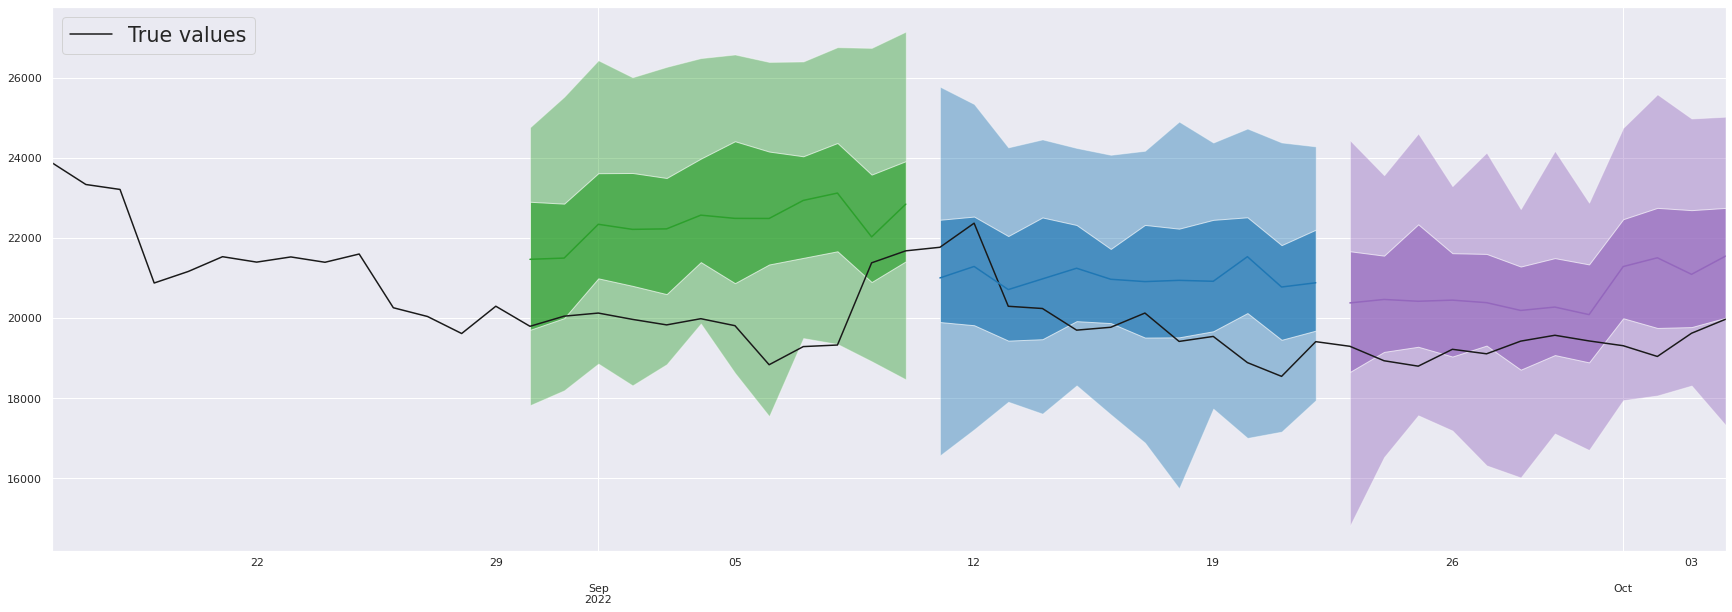

In [174]:
estimator = TransformerEstimator(prediction_length=12, freq=freq, trainer=Trainer(epochs=5))
predictor = estimator.train(training_data=train_ds)

# Make predictions
true_values = to_pandas(list(test_ds)[0])
true_values[-50:].to_timestamp().plot(color="k")

prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-12]])
predictions = model.predict(prediction_input)

for color, prediction in zip(["green", "blue", "purple"], predictions):
    prediction.plot(color=f"tab:{color}")

plt.legend(["True values"], loc="upper left", fontsize="xx-large")

In [177]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

In [178]:
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(
    -1,
)
dataset_test_entry = next(iter(test_ds))
dataset_test_entry["target"][:5]


array([32127.268, 32782.023, 31971.914, 33992.43 , 36824.363],
      dtype=float32)

array([32127.268, 32782.023, 31971.914, 33992.43 , 36824.363],
      dtype=float32)

In [179]:
forecast_entry = forecasts[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 12)
Start date of the forecast window: 2022-09-23
Frequency of the time series: <Day>


In [180]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [20274.215 20090.148 19870.33  19632.582 19955.154 19502.328 19692.506
 19748.852 20502.943 19941.225 20107.87  20663.516]
0.5-quantile (median) of the future window:
 [20454.787 20061.666 20073.523 19992.21  20074.963 19599.309 19573.03
 19803.648 20279.164 19763.754 20362.424 20856.705]


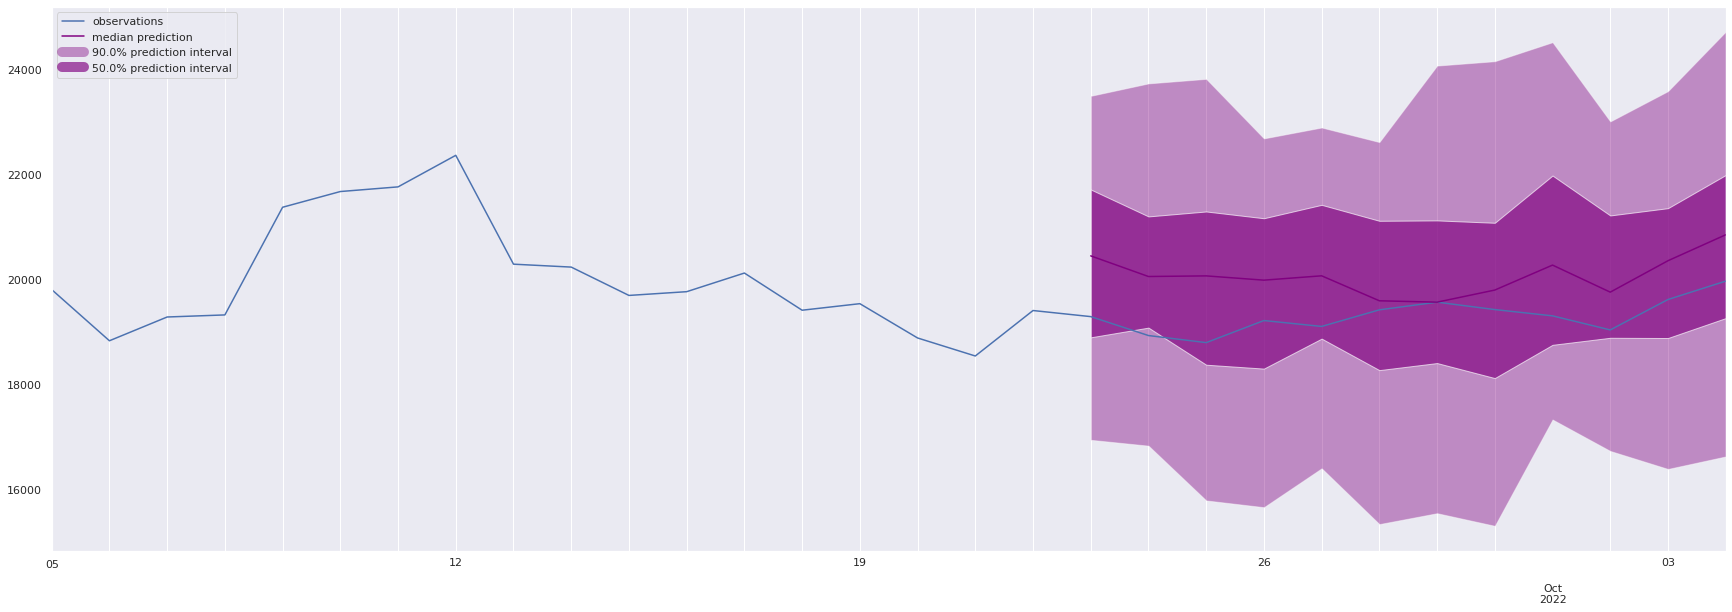

In [201]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 30
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + \
             [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1)
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="purple")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(ts_entry, forecast_entry)


In [203]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)
print(json.dumps(agg_metrics, indent=4))


Running evaluation: 1it [00:00,  1.47it/s]

{
    "MSE": 613297.2083333334,
    "abs_error": 9140.0703125,
    "abs_target_sum": 231755.15625,
    "abs_target_mean": 19312.9296875,
    "seasonal_error": 1157.6249004777071,
    "MASE": 0.6579614223289028,
    "MAPE": 0.03960078954696655,
    "sMAPE": 0.038643017411231995,
    "MSIS": 8.434906962785544,
    "QuantileLoss[0.1]": 5093.0662109375,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 9140.0703125,
    "Coverage[0.5]": 0.9166666666666666,
    "QuantileLoss[0.9]": 7882.665624999999,
    "Coverage[0.9]": 1.0,
    "RMSE": 783.1329442267981,
    "NRMSE": 0.040549670966475326,
    "ND": 0.039438476625048124,
    "wQuantileLoss[0.1]": 0.021976064279853536,
    "wQuantileLoss[0.5]": 0.039438476625048124,
    "wQuantileLoss[0.9]": 0.034012902895229534,
    "mean_absolute_QuantileLoss": 7371.934049479166,
    "mean_wQuantileLoss": 0.03180914793337706,
    "MAE_Coverage": 0.20555555555555552,
    "OWA": NaN
}
